In [ ]:
import json

def load_and_process_json(file_path, exclude_words):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    unique_shapes = []
    
    for library in data:
        shape = library["shape"]  
        shape_str = str(shape).lower()
        
        if not any(word.lower() in shape_str for word in exclude_words):
            if shape not in unique_shapes:
                unique_shapes.append(shape)
    
    return unique_shapes

file_path = 'database/updated_all_sat.json'
exclude_words = ['sphere', 'cyl', 'box', 'cone', 'dome'] 
result = load_and_process_json(file_path, exclude_words)
print(len(result))
print("Unique shapes (excluding entries with {}):\n".format(exclude_words), result)

[    0.    60.   120.   180.   240.   300.   360.   420.   480.   540.
   600.   660.   720.   780.   840.   900.   960.  1020.  1080.  1140.
  1200.  1260.  1320.  1380.  1440.  1500.  1560.  1620.  1680.  1740.
  1800.  1860.  1920.  1980.  2040.  2100.  2160.  2220.  2280.  2340.
  2400.  2460.  2520.  2580.  2640.  2700.  2760.  2820.  2880.  2940.
  3000.  3060.  3120.  3180.  3240.  3300.  3360.  3420.  3480.  3540.
  3600.  3660.  3720.  3780.  3840.  3900.  3960.  4020.  4080.  4140.
  4200.  4260.  4320.  4380.  4440.  4500.  4560.  4620.  4680.  4740.
  4800.  4860.  4920.  4980.  5040.  5100.  5160.  5220.  5280.  5340.
  5400.  5460.  5520.  5580.  5640.  5700.  5760.  5820.  5880.  5940.
  6000.  6060.  6120.  6180.  6240.  6300.  6360.  6420.  6480.  6540.
  6600.  6660.  6720.  6780.  6840.  6900.  6960.  7020.  7080.  7140.
  7200.  7260.  7320.  7380.  7440.  7500.  7560.  7620.  7680.  7740.
  7800.  7860.  7920.  7980.  8040.  8100.  8160.  8220.  8280.  8340.
  8400

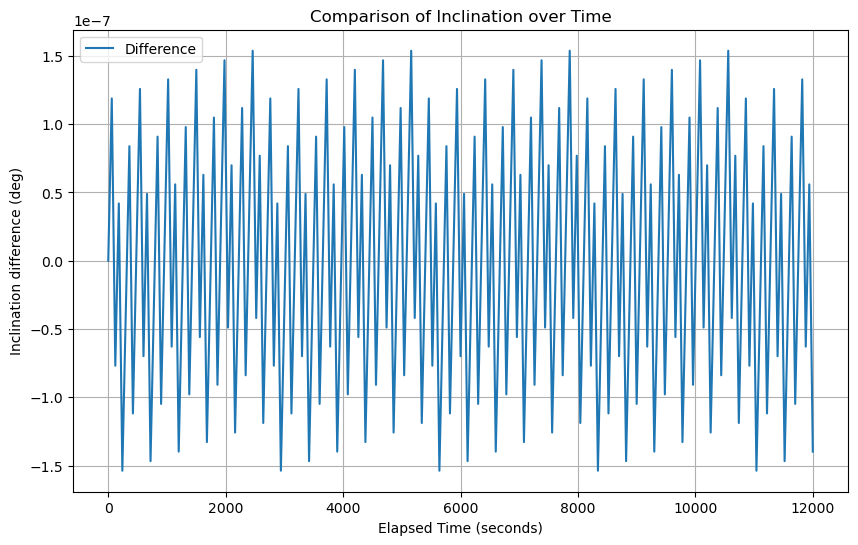

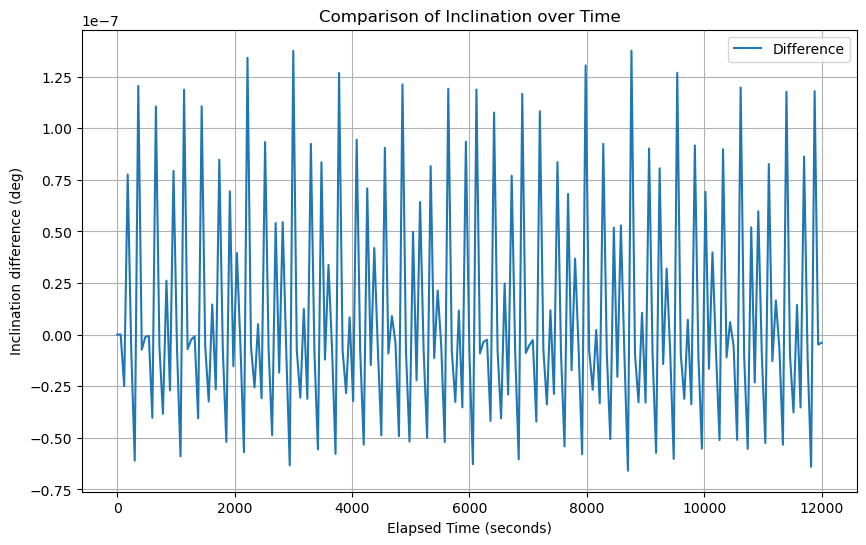

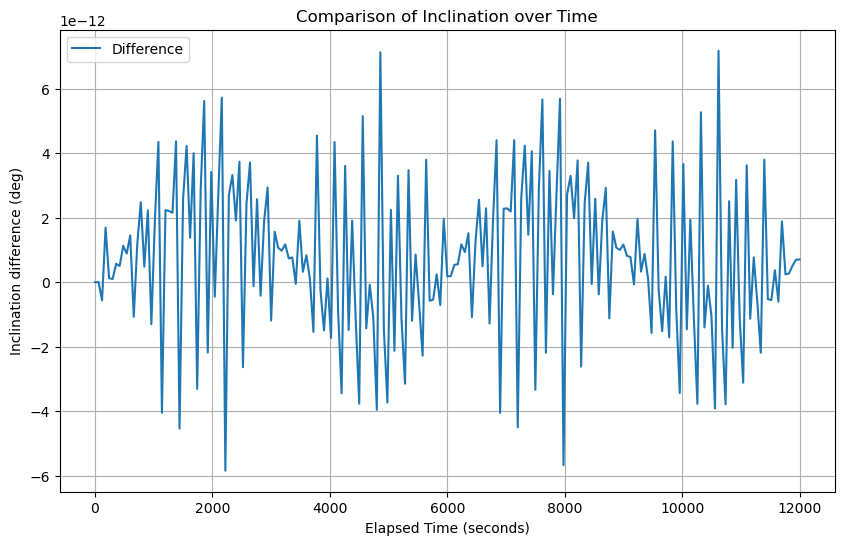

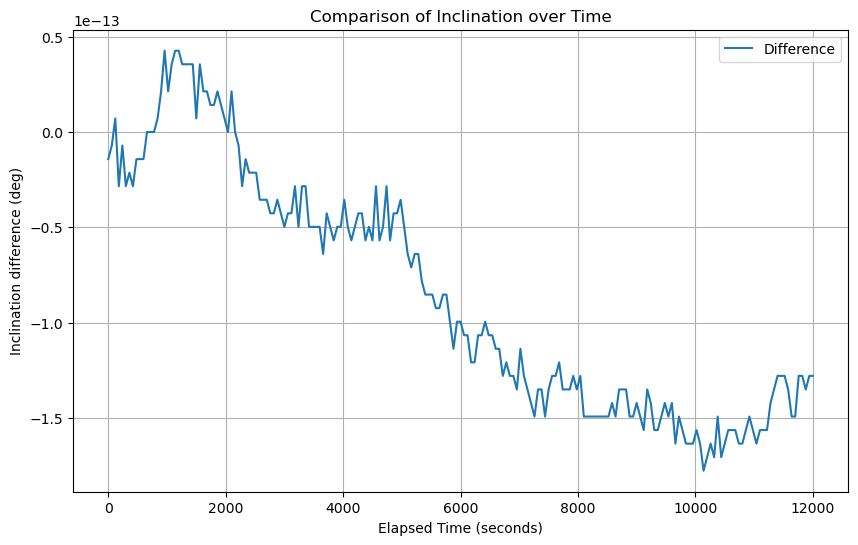

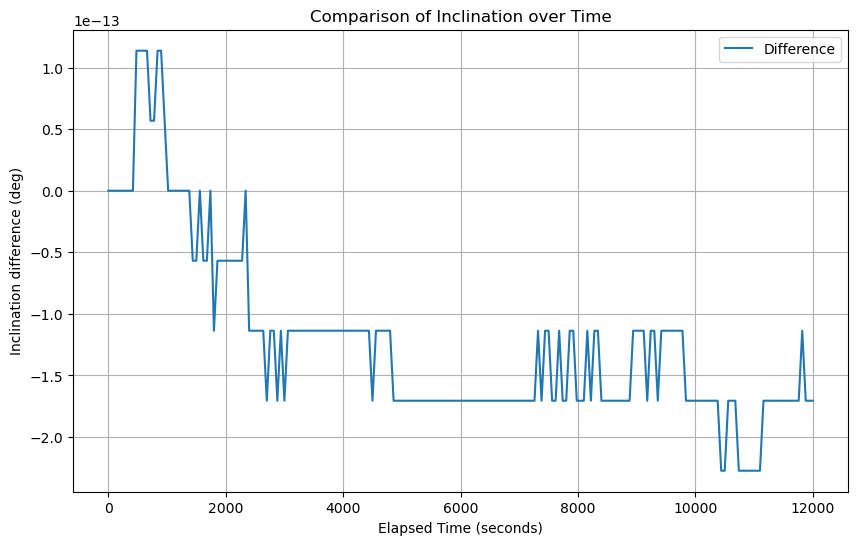

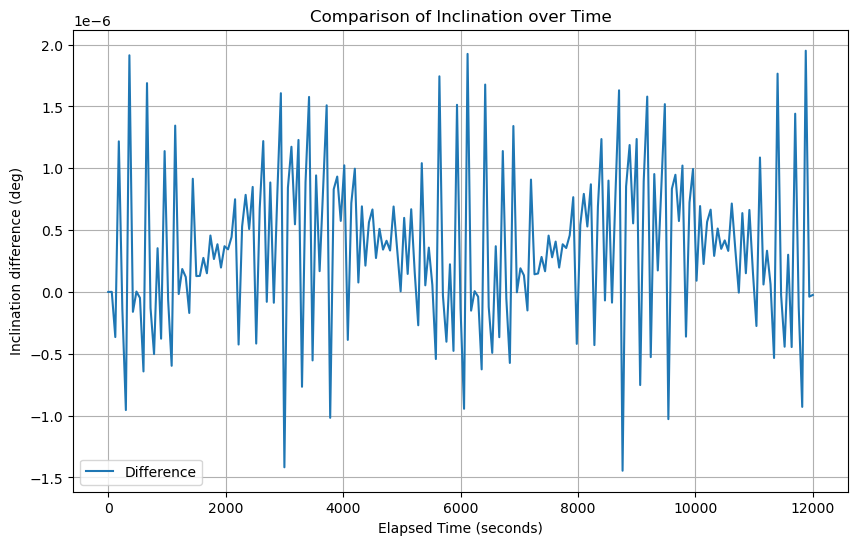

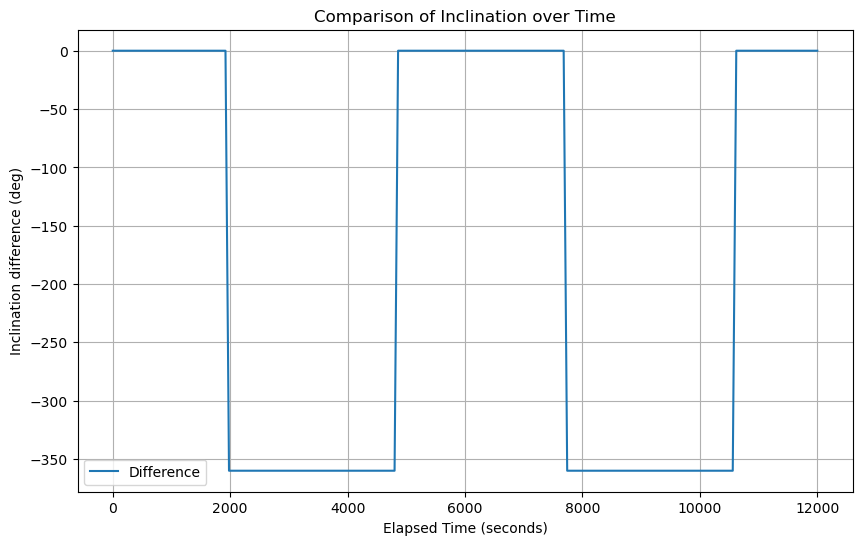

In [42]:
from astropy import units as u
from poliastro.bodies import Earth, Moon
from poliastro.twobody import Orbit
from poliastro.core.propagation import cowell
import numpy as np
from poliastro.core.propagation.farnocchia import (
    farnocchia_coe as farnocchia_coe_fast,
    farnocchia_rv as farnocchia_rv_fast,
)
from poliastro.core.propagation import danby
from poliastro.core.propagation import pimienta
from poliastro.twobody.propagation.vallado import vallado

import datetime
from datetime import datetime, timedelta
from astropy.time import Time
from poliastro.util import time_range
from poliastro.core.elements import rv2coe

from astropy import units as u
from astropy.coordinates import GCRS, ITRS, CartesianRepresentation, CartesianDifferential
from astropy.time import Time

import matplotlib.pyplot as plt
import numpy as np




def from_ECI_to_ECEF(ECI_pos, ECI_vel, time_array):
    ECEF_pos = []
    ECEF_vel = []
    
    for r, v, epoch in zip(ECI_pos, ECI_vel, time_array):
        pos = CartesianRepresentation(x=r[0]*u.km, y=r[1]*u.km, z=r[2]*u.km)
        vel = CartesianDifferential(d_x=v[0]*u.km/u.s, d_y=v[1]*u.km/u.s, d_z=v[2]*u.km/u.s)

        eci = GCRS(pos.with_differentials(vel), obstime=Time(epoch))
        
        ecef = eci.transform_to(ITRS(obstime=Time(epoch)))
        
        ECEF_pos.append([ecef.x.value, ecef.y.value, ecef.z.value])
        ECEF_vel.append([ecef.velocity.d_x.value, ecef.velocity.d_y.value, ecef.velocity.d_z.value])
    
    ECEF_pos = np.array(ECEF_pos)
    ECEF_vel = np.array(ECEF_vel)

    return ECEF_pos, ECEF_vel


a = 6937.189 * u.km
ecc = 0.00023600 * u.one
inc = 43.0050 * u.deg
raan = 319.1954 * u.deg
argp = 301.2015 * u.deg
nu = 58.8828 * u.deg
epoch = Time(datetime.strptime("2024-09-05 13:17:21.016608", "%Y-%m-%d %H:%M:%S.%f"), 
                                    scale="utc", 
                                    format="datetime"
                )
initial_orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, epoch)


r0 = initial_orbit.r.to(u.km).value
v0 = initial_orbit.v.to(u.km / u.s).value

prop_time = 200
start_date = epoch
start_date = Time(start_date, scale="utc", format="datetime")
end_date = start_date + timedelta(minutes=prop_time)
epochs = time_range(start_date, periods=prop_time, end=end_date)


tofs = np.linspace(0, 60*200, 201) 
print(tofs)

k = Earth.k.to(u.km**3 / u.s**2).value


# COWELL
rr_cowell, vv_cowell = cowell(k, r0, v0, tofs)
rr_cowell = np.array(rr_cowell)
vv_cowell = np.array(vv_cowell)
rr_cowell_ECEF, vv_cowell_ECEF = from_ECI_to_ECEF (rr_cowell, vv_cowell, epochs)


# Convert r and v to COE
coe_elements = []
for r, v, elapsedsecs in zip(rr_cowell, vv_cowell, tofs):
    p, ecc, inc, raan, argp, nu = rv2coe(k, r, v)
    inc_deg, raan_deg, argp_deg, nu_deg = np.degrees([inc, raan, argp, nu])
    a = p / (1 - ecc**2)
    nu_deg = nu_deg
    coe_elements.append((elapsedsecs, a, ecc, inc_deg, raan_deg, argp_deg, nu_deg))

data = np.loadtxt('simulation_ECI.txt', skiprows=1)
coe_elements_precise = [
    (row[0],  # elapsed seconds
     row[1],  # a
     row[4],  # ecc
     row[5],  # inc
     row[3],  # raan
     row[6],  # argp
     row[2])  # nu (true anomaly)
    for row in data
]

i=6
time_cowell = [element[0] for element in coe_elements]
y_cowell = [element[i] for element in coe_elements]

time_precise = [element[0] for element in coe_elements_precise]
y_precise = [element[i] for element in coe_elements_precise]

y_diff = np.array(y_cowell) - np.array(y_precise)

plt.figure(figsize=(10, 6))
plt.plot(time_cowell, y_diff, label='Difference')
# plt.plot(time_cowell, y_cowell, label='Cowell')
# plt.plot(time_precise, y_precise, label='Precise')

plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Inclination difference (deg)')
plt.title('Comparison of Inclination over Time')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Moon
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (
    atmospheric_drag_exponential,
    third_body,
    J2_perturbation,
)
from poliastro.core.propagation import func_twobody
from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter3D
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray
from poliastro.util import norm

